### Summary
On top of the techniques we previously learned, this notebook deploys the techniques mentioned in Dog Breeds examples:
1. Subsequently increasing image size in traning
2. Doing exploratory analysis on image size distribution
3. (Using resnext model)

Issues:
1. To make Resnext101 work well: https://forums.fast.ai/t/lesson-2-in-class-discussion/7452/317?u=ianianian
2. learn.fit() has rint issue (i.e. AttributeError: 'float' object has no attribute 'rint')


In [0]:
#Automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import matplotlib.pyplot as plt

In [0]:
PATH = '/content/selected_gd_data/'
# image size may need to adjust
sz = 224

#### 1. Enable Data  Augementation

In [0]:
arch = resnet34
# flip sideways, vary the contrast, blur, zoom-in
tfms = tfms_from_model(resnet34, 
                       sz, 
                       # transform_top_down: flip vertically
                       # transform_side_on: flip horizontally
                       aug_tfms = transforms_side_on,
                       max_zoom = 1.1)

In [0]:
def get_augs():
  data = ImageClassifierData.from_paths(PATH, 
                                        bs = 2,
                                        trn_name = 'imgtrain',
                                        val_name = 'imgval',
                                        tfms = tfms, 
                                        num_workers = 1)
  x, _ = next(iter(data.aug_dl))
  return data.trn_ds.denorm(x)[1]

In [0]:
ims = np.stack([get_augs() for i in range(6)])

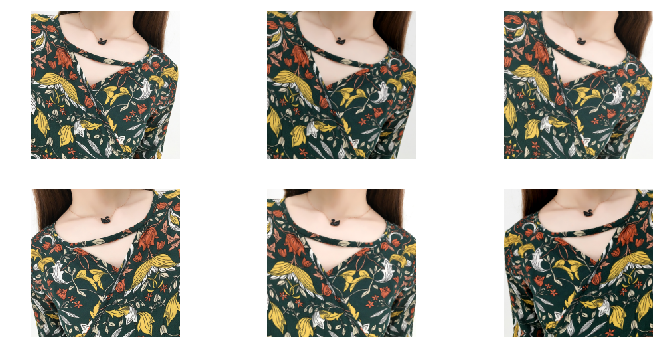

In [6]:
plots(ims, rows = 2)

#### 2. Query Images Sizes


In [0]:
import PIL

In [0]:
# Create a new data object with augmented data included
data = ImageClassifierData.from_paths(PATH, 
                                      tfms = tfms,
                                      trn_name = 'imgtrain',
                                      val_name = 'imgval')

In [0]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}

In [0]:
row_sz, col_sz = list(zip(*size_d.values()))
row_sz = np.array(row_sz)
col_sz = np.array(col_sz)

(array([  26.,  234.,  637., 1735., 8303.,  472.,  313.,  122.,   20.,   95.]),
 array([  33. ,  221.7,  410.4,  599.1,  787.8,  976.5, 1165.2, 1353.9, 1542.6, 1731.3, 1920. ]),
 <a list of 10 Patch objects>)

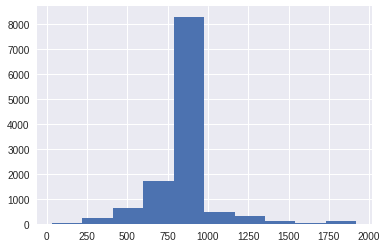

In [11]:
plt.hist(row_sz)

(array([  31.,  776., 9200.,  969.,  519.,  188.,   73.,  199.,    0.,    2.]),
 array([  51. ,  307.1,  563.2,  819.3, 1075.4, 1331.5, 1587.6, 1843.7, 2099.8, 2355.9, 2612. ]),
 <a list of 10 Patch objects>)

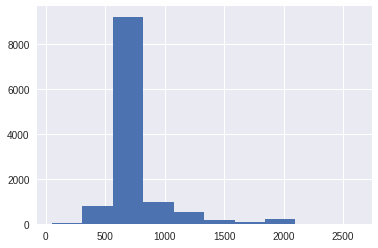

In [12]:
plt.hist(col_sz)

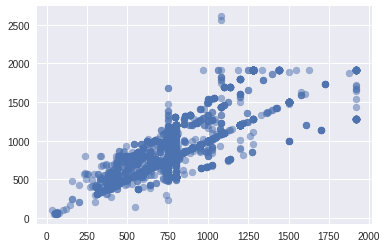

In [13]:
plt.scatter(x = row_sz, y = col_sz, alpha = 0.5);

#### 3. Adjust Data Size


In [0]:
def get_data(sz, bs):
  tfms = tfms_from_model(arch, sz, aug_tfms = transforms_side_on, max_zoom = 1.1)
  data = ImageClassifierData.from_paths(PATH,
                                        tfms = tfms,
                                        trn_name = 'imgtrain',
                                        val_name = 'imgval',
                                        bs = bs)
  return data if sz>300 else data.resize(340, 'tmp')

In [15]:
data = get_data(sz, 64)

#### 2. Find Suitable Learning Rate

In [16]:
# when precompute = True, data augmentation not work
learn = ConvLearner.pretrained(arch, data, precompute = True)

lrf = learn.lr_find(1e-6,1e1)

 86%|████████▌ | 161/187 [00:03<00:00, 36.60it/s, loss=6.2] 


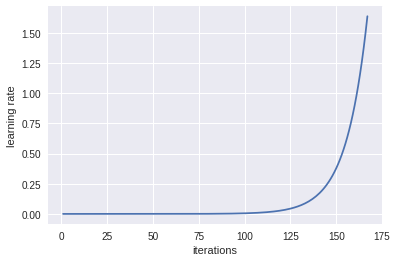

In [17]:
learn.sched.plot_lr()

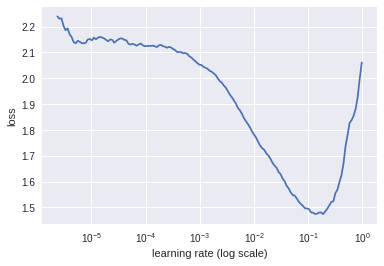

In [18]:
# Find the learning rate with highest decrease in loss function
# From the graph, lr = 0.01 is appropriate
learn.sched.plot()

#### 3. Train Last Layers with Precomputed Activation

In [19]:
# This learning has no data augmentation included
learn.fit(0.01, 2)

epoch      trn_loss   val_loss   accuracy   



AttributeError: ignored

#### 6. Find Suitable Learning Rate again

In [0]:
lrf = learn.lr_find(1e-40,1e-27)

epoch      trn_loss   val_loss   accuracy   
    0      0.277776   0.487853   0.828438  


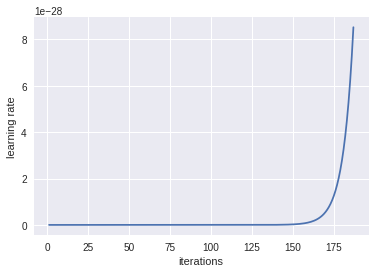

In [0]:
learn.sched.plot_lr()

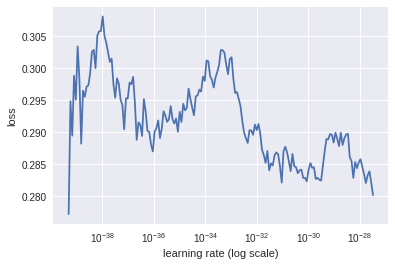

In [0]:
# Optimal learning rate completely change
# lr = 1e-33 seems to be suitable
learn.sched.plot()

#### 5. Train Last Layers with Data Augmentation

In [20]:
# set precompute = False and learn again
# This time augmented data is included
learn.precompute = False

# cycle_len = 1
# [learning rate (cosine) annealing] decrease learning rate with iterations
# reset learning rate to its peak at every epoch
# gradually decrease learning rate for each minibatch
# Note that we are training the last layer (randomly initialized)
learn.fit(1e-33, 2, cycle_len = 1)

epoch      trn_loss   val_loss   accuracy   


AttributeError: ignored

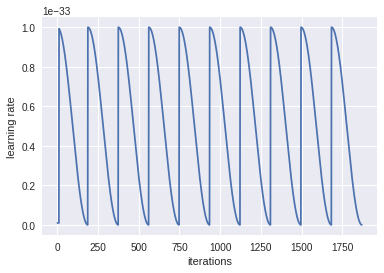

In [0]:
learn.sched.plot_lr()

In [0]:
# save the model
# It is saved in {PATH}/models
learn.save('224_dress_lastlayer')
# load in the model
learn.load('224_dress_lastlayer')

#### 6. Unfreeze All Layers

In [0]:
# unfreeze the remaining layers
# unfreeze layer from n onwards
learn.unfreeze()

#### 7. Find Suitable Learning Rate Again

In [0]:
# Let's see if the optimal learning rate has changed after we trained the un-precomputed last layer
lrf = learn.lr_find(1e-40,1e-20)

epoch      trn_loss   val_loss   accuracy   
    0      0.936066   0.715833   0.761682  


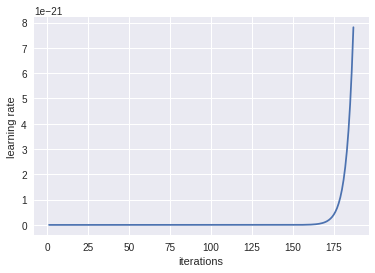

In [0]:
learn.sched.plot_lr()

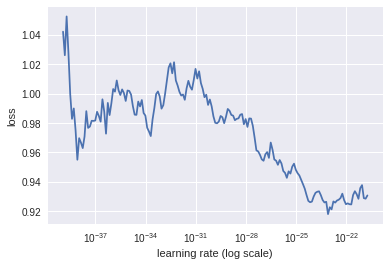

In [0]:
# Find the learning rate with highest decrease in loss function
# From the graph, lr = 1e-25 - 1e-27 is appropriate
learn.sched.plot()

#### 8. Apply Differential Learning Rate

In [0]:
# The most shallow layers need little training
# The deepest layers need more training
# shallow > middle > deep
lr = np.array([1e-27, 1e-26, 1e-25])

In [0]:
# stochastics gradient descent: cycle_len = 1
# number of cycles = 3
# each cycle contains 2 epoch
# cycle_mult = 2 - Double the length of cycle for each cycle
# 1 + 2 + 4 epochs
learn.fit(lr, 5, cycle_len = 1, cycle_mult = 2)

epoch      trn_loss   val_loss   accuracy   
    0      0.914693   0.729068   0.739653  
    1      0.970085   0.741786   0.733645  
    2      0.915163   0.735371   0.732977  
 64%|██████▎   | 119/187 [03:08<01:30,  1.32s/it, loss=0.922]

KeyboardInterrupt: ignored

#### 9. Analysis of Results
1. Confusion Matrix (with and ithout Test Time Augmentation)
2. Sample Check

In [0]:
!ls

adc.json       lr_plot.png  sample_data       selected_gd_data_5.zip
colab_util.py  __pycache__  selected_gd_data
